<a href="https://colab.research.google.com/github/tensorflow-project/FineTuning/blob/main/four_emotions/training_four_emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/tensorflow-project/FineTuning

Cloning into 'FineTuning'...
remote: Enumerating objects: 1573, done.
remote: Counting objects: 100% (301/301), done.
remote: Compressing objects: 100% (226/226), done.
remote: Total 1573 (delta 183), reused 134 (delta 71), pack-reused 1272
Receiving objects: 100% (1573/1573), 166.35 MiB | 30.80 MiB/s, done.
Resolving deltas: 100% (1131/1131), done.


In [2]:
import sys
import os
from google.colab import drive
import numpy as np

py_file_location = "/content/FineTuning/four_emotions"
sys.path.append(os.path.abspath(py_file_location))
py_file_location = "/content/FineTuning/models"
sys.path.append(os.path.abspath(py_file_location))

import textual_inversion_four_emotions as txt

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE
202761/202761 [==============================] - 0s 0us/step


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


136824240/136824240 [==============================] - 2s 0us/step


In [3]:
### embeddings for cosine similarity
sticker_embedding = []
cosine_similarity = []
cosine_similarity.append(txt.cosine_sim(txt.get_embedding("broccoli"), txt.get_embedding(txt.placeholder_token)))

In [10]:
### EXECUTE THE FOLLOWING TWO BLOCKS ONLY IF YOU WANT TO CONTINUE TRAINING WITH SAVED WEIGTHS
### choose where to load the weights from, either from your google drive or you load our pretrained weights
### make sure to insert the exact name of your weight.npy
drive.mount("/content/drive")
path = '/content/drive/MyDrive/weight_four_emotions.npy'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
###load the array of the weights of the text encoder from the training
text_encoder_weights = np.load(path, allow_pickle=True)

### Set the weights of the text encoder
txt.stable_diffusion.text_encoder.set_weights(text_encoder_weights)

Epoch 1/1: 100%|██████████| 535/535 [15:16<00:00,  1.71s/it]


31/31 [==============================] - 108s 3s/step


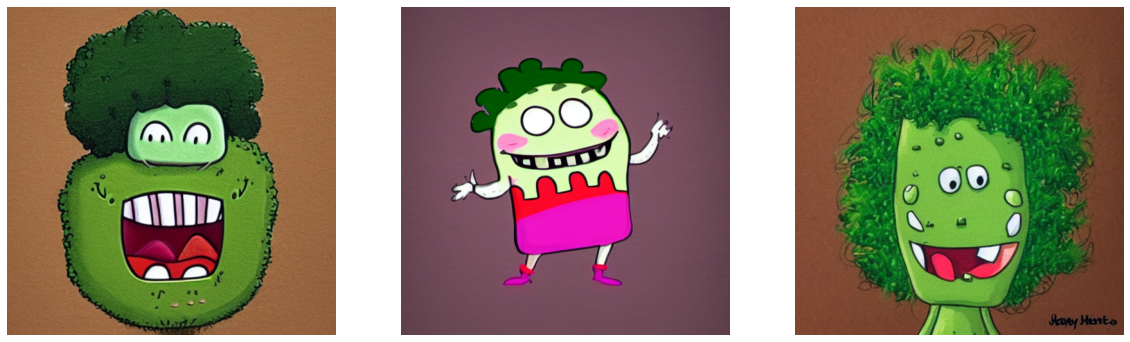

In [5]:
### how long to train for
epochs = 1
epoch_num = list(range(epochs+1))
txt.training(epoch=epochs, model=txt.stable_diffusion, data=txt.train_ds, sticker_embedding=sticker_embedding, cosine_similarity=cosine_similarity)

In [6]:
### where to store your newly generated weights
drive.mount("/content/drive")
path = '/content/drive/MyDrive/weights_four_emotions.npy'

Mounted at /content/drive


In [7]:
### get the weights of the text encoder and save the to Google Drive
text_encoder_weights = np.array(txt.stable_diffusion.text_encoder.get_weights(), dtype=object)

### save the weights array to a file on your Google Drive
np.save(path, text_encoder_weights)

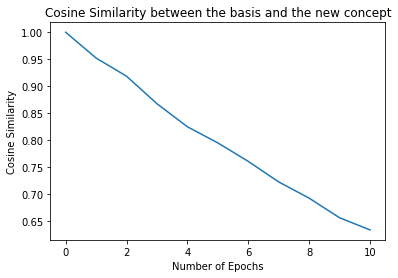

In [ ]:
### plot cosine similarity between old and new embedding
txt.cosine_plot(epoch_num, cosine_similarity)